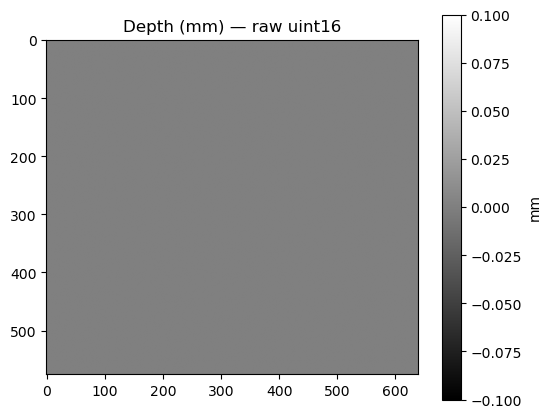

Unprojected point‑cloud has 0 points
No points! Depth is all zeros.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyorbbecsdk import Pipeline, Config, OBSensorType

# 1) Start camera with depth only
pipeline = Pipeline()
cfg      = Config()
depth_prof = pipeline.get_stream_profile_list(OBSensorType.DEPTH_SENSOR) \
                    .get_default_video_stream_profile()
cfg.enable_stream(depth_prof)
pipeline.start(cfg)

# 2) Grab one depth frame (timeout 1 s)
frames = pipeline.wait_for_frames(1000)
if frames is None:
    raise RuntimeError("Timeout waiting for frames")

d = frames.get_depth_frame()
dh, dw = d.get_height(), d.get_width()
depth = np.frombuffer(d.get_data().tobytes(), dtype=np.uint16).reshape((dh, dw))

# 3) Visualize the raw depth map
plt.figure(figsize=(6,5))
plt.imshow(depth, cmap='gray')
plt.title("Depth (mm) — raw uint16")
plt.colorbar(label="mm")
plt.show()

# 4) Unproject into 3D (meters)
intr = depth_prof.get_intrinsic()
fx, fy, cx, cy = intr.fx, intr.fy, intr.cx, intr.cy

us, vs = np.meshgrid(np.arange(dw), np.arange(dh))
zs = depth.astype(float) * 0.001   # convert mm→m
mask = zs > 0
xs = (us[mask] - cx) * zs[mask] / fx
ys = (vs[mask] - cy) * zs[mask] / fy
pts = np.stack((xs, ys, zs[mask]), axis=-1)

print(f"Unprojected point‑cloud has {pts.shape[0]} points")

# 5) If there are any points, show a small 3D scatter
if pts.shape[0]:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    # down‑sample if too many:
    sample = pts[:: max(1, pts.shape[0]//50000)]
    ax.scatter(sample[:,0], sample[:,1], sample[:,2], s=0.5)
    ax.set_title("Point‑cloud scatter (down‑sampled)")
    plt.show()
else:
    print("No points! Depth is all zeros.")

# 6) Stop the camera
pipeline.stop()


In [6]:
from pyorbbecsdk import Pipeline, Config, OBSensorType
import numpy as np

# 1) Configure and start only the depth stream
cfg = Config()
cfg.enable_stream(OBSensorType.DEPTH_SENSOR)

pipe = Pipeline()
pipe.start(cfg)

# 2) Wait for one set of frames
frames = pipe.wait_for_frames(1000)
if frames is None:
    print("No frameset received; check device permissions or that no other app is holding it")
else:
    # 3) Pull the depth frame
    d_frame = frames.get_depth_frame()
    if d_frame is None:
        print("Depth frame is None; the depth sensor didn’t deliver data")
    else:
        # 4) Convert to numpy and reshape
        h, w = d_frame.get_height(), d_frame.get_width()
        buf  = d_frame.get_data().tobytes()
        depth = np.frombuffer(buf, dtype=np.uint16).reshape((h, w))

        # 5) Compute stats
        nz = np.count_nonzero(depth)
        print(f"Depth stats → min: {depth.min()}, max: {depth.max()}, non‑zero: {nz}/{h*w}")

# 6) Clean up
pipe.stop()



Depth stats → min: 0, max: 0, non‑zero: 0/368640


In [7]:
from pyorbbecsdk import Pipeline, Config, OBSensorType
import numpy as np

# 1) Build a Config that enables BOTH the depth and IR sensors
cfg = Config()
cfg.enable_stream(OBSensorType.DEPTH_SENSOR)
cfg.enable_stream(OBSensorType.IR_SENSOR)

# 2) Start the pipeline with that config
pipe = Pipeline()
pipe.start(cfg)

# 3) Give it a quick warm‑up
import time; time.sleep(1.0)

# 4) Wait for one set of frames (timeout = 1000 ms)
frames = pipe.wait_for_frames(1000)
if frames is None:
    print("No frameset received; check that no other app is holding the camera")
else:
    # 5) Pull the depth frame
    d_frame = frames.get_depth_frame()
    if d_frame is None:
        print("Depth frame is None; the depth sensor didn’t deliver data")
    else:
        # 6) Convert to NumPy and reshape
        h, w = d_frame.get_height(), d_frame.get_width()
        buf  = d_frame.get_data().tobytes()
        depth = np.frombuffer(buf, dtype=np.uint16).reshape((h, w))

        # 7) Compute & print stats
        nz = np.count_nonzero(depth)
        print(f"Depth stats → min: {depth.min()}, max: {depth.max()}, non‑zero: {nz}/{h*w}")

# 8) Clean up
pipe.stop()


Depth stats → min: 0, max: 0, non‑zero: 0/368640


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Choose the Y16 device and mode
DEVICE = "/dev/video2"
WIDTH, HEIGHT, FPS = 640, 576, 30

# 2) Build a GStreamer pipeline that requests Y16 at 640×576 @ 30 fps
GST_PIPE = (
    f"v4l2src device={DEVICE} ! "
    f"video/x-raw,format=Y16,width={WIDTH},height={HEIGHT},framerate={FPS}/1 ! "
    f"appsink drop=true max-buffers=1"
)

# 3) Open in OpenCV
cap = cv2.VideoCapture(GST_PIPE, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    raise RuntimeError(f"Failed to open depth device at {DEVICE!r}")

# 4) Read one frame
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Failed to read a frame from the device")

# 5) Convert to uint16 (should already be uint16 single‑channel)
if frame.dtype != np.uint16:
    # sometimes OpenCV shows two 8‑bit channels; reinterpret if needed:
    frame = frame.view(np.uint16)

depth = frame.reshape((HEIGHT, WIDTH))

# 6) Print stats
nz = np.count_nonzero(depth)
print(f"Depth ({WIDTH}×{HEIGHT}) → min={depth.min()}  max={depth.max()}  non‑zero={nz}/{WIDTH*HEIGHT}")

# 7) Visualize inline
plt.figure(figsize=(6,5))
plt.imshow(depth, cmap="gray")
plt.title("Raw depth (Y16)")
plt.colorbar(label="mm")
plt.axis("off")
plt.show()



RuntimeError: Failed to open depth device at '/dev/video2'

In [18]:
import cv2, numpy as np

DEVICE = "/dev/video2"   # the node that lists Y16 in --list-formats-ext
WIDTH, HEIGHT, FPS = 640, 576, 30

GST_PIPE = (
    f"v4l2src device={DEVICE} ! "
    f"video/x-raw,format=Y16,width={WIDTH},height={HEIGHT},framerate={FPS}/1 ! "
    f"appsink drop=true max-buffers=1"
)

cap = cv2.VideoCapture(GST_PIPE, cv2.CAP_GSTREAMER)
ret, frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Failed to read")
depth = frame.astype(np.uint16)  # shape (576,640), mm values

print("Depth stats →",
      "min:", depth.min(),
      "max:", depth.max(),
      "non-zero:", np.count_nonzero(depth))


RuntimeError: Failed to read